In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.visualization import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.dataset import EstimateBackground
import h5py
from decode_fish.funcs.routines import *
from decode_fish.funcs.output_trafo import *

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

### Testing if the intensity values I gathered (and resacled from their code) give the optimal reconstruction.
Steps:
- Use GT psf
- Simple rescaling as int = int_matlab * 65535.0 / 100.0 given that we also renormalize by the max. (100 is micro scaling)
- Substract GT bg

There remains a 1.23 scaling factor which I can't account for

In [10]:
gt_psf = cpu(load_tiff_image('figures/PSF_subsampled.tif')[0])
bg_gt = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/bg_tifs/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_10.tif')
shift = [-2.7841719258038293, 23.54306753522399, 35.68335102059248]

In [22]:
cfg = OmegaConf.load('config/train.yaml')
cfg.microscope.scale = 100
cfg.data_path.psf_path = 'figures/PSF_subsampled.tif'
_, noise, _ = load_psf_noise_micro(cfg)
gtmicro = hydra.utils.instantiate(cfg.microscope, parametric_psf=[load_psf(cfg)], noise=noise).cuda()

In [18]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', 0)

In [19]:
rec_gt = cpu(get_reconstruction_from_df(gt_df, gtmicro, img.shape, [300,100,100]))[0,0]
gt_img = cpu(img - bg_gt)[0]

In [66]:
rmses = []
for i in np.linspace(1.,2,100):
    tra = gt_df.copy()
    tra['int'] = tra['int'] / i
    tra['z'] = tra['z'] - 55 + 300
    tra['y'] = tra['y'] - 16 + 100
    tra['x'] = tra['x'] - 16 + 100
    
    rec_gt = cpu(get_reconstruction_from_df(tra, gtmicro, img.shape, [300,100,100]))[0,0]
    rmses.append(np.sqrt(np.mean((rec_gt-gt_img)**2)))

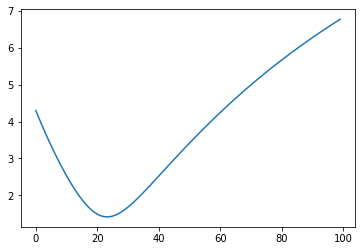

In [67]:
plt.plot(rmses)

In [68]:
tra = gt_df.copy()
tra['int'] = tra['int'] / 1.23
tra['z'] = tra['z'] - 55 + 300
tra['y'] = tra['y'] - 16 + 100
tra['x'] = tra['x'] - 16 + 100

rec_gt = cpu(get_reconstruction_from_df(tra, gtmicro, img.shape, [300,100,100]))[0,0]
print(np.sqrt(np.mean((rec_gt-gt_img)**2)))

1.4166409


array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

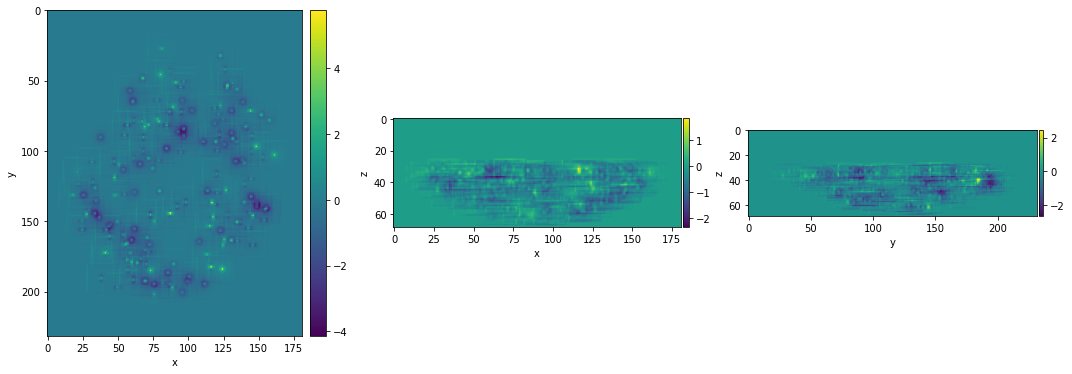

In [69]:
plot_3d_projections(gt_img-rec_gt,'mean')